In [1]:
"""
Summaries of USFS TreeMap linked to FIA plot data
Emphasis on 
    - Metrics of forest composition
    - Ecological gradients of species dominance
    - Forest structure (abundance, dominance, diversity, stand height)

Aggregate these statistics to FRP gridcells.

Author: maxwell.cook@colorado.edu
"""

import os, sys

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

albers = 'EPSG:5070' # albers CONUS
utm = 'EPSG:32613' # UTM Zone 13N

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [2]:
# load the aggregated FRP grids (regular 375m2 grids summarizing FRP from VIIRS)
fp = os.path.join(projdir,'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_fires_pixar_gridstats.gpkg')
grid = gpd.read_file(fp)
print(f"\nThere are [{len(grid)}] grids across [{len(grid['Fire_ID'].unique())}] fires.\n")

# add the centroid lat/lon to the grid data
df = grid.to_crs(4326) # WGS coords for lat/lon
df['x'] = df.geometry.centroid.x  # Longitude (x-coordinate)
df['y'] = df.geometry.centroid.y
grid = grid.merge(df[['grid_index','x','y']], on='grid_index', how='left')
del df
print(f"\n{grid.columns}\n")

# Drop any dupicate grids ...
print(f"Dropping [{grid.duplicated(subset=['grid_index']).sum()}] duplicate grids.\n")
grid = grid.drop_duplicates(subset=['grid_index'], keep='first')

# check on fractional overlap distribution
print(f"Fractional overlap:\n{grid['overlap'].describe()}\n")
n_small = grid[grid['overlap'] < 0.05]['grid_index'].count() # less than 5% spatial overlap
print(f"Dropping [{n_small} ({round(n_small/len(grid)*100,2)}%)] grids with < 5% fractional overlap.")
grid = grid[grid['overlap'] >= 0.05] # remove these observations


There are [57232] grids across [100] fires.


Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'x', 'y'],
      dtype='object')

Dropping [1395] duplicate grids.

Fractional overlap:
count    56767.000000
mean         2.029756
std          2.004417
min          0.000003
25%          0.591083
50%          1.498852
75%          2.779104
max         24.470760
Name: overlap, d

In [3]:
# Load the TreeMap (ca. 2016)
# Pixel values here denote the FIA plot ID ("tm_id")
# see '04a_TreeMap_FIA-Prep.ipynb'
# fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016.tif') # tm_id band
fp = os.path.join(projdir, "data/spatial/mod/USFS/TreeMap_2016_TMID_FORTYPCD.tif") # multi-band
treemap_da = rxr.open_rasterio(fp, masked=True, cache=False).squeeze()
tmid_da = treemap_da.sel(band=1) # the "tm_id" band

# Grab some raster metadata from one of the layers
shp, gt, wkt, nd = tmid_da.shape, tmid_da.spatial_ref.GeoTransform, tmid_da.rio.crs, tmid_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {tmid_da[0].dtype}")

del treemap_da
gc.collect()

Shape: (28724, 17006); 
GeoTransform: -1193295.0 30.0 0.0 2253345.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32


28

In [4]:
# create a forest/non-forest grid
forest_mask = xr.where(~np.isnan(tmid_da), 1, 0)
# calculate the total forested pixels
# see __functions.py 'compute_band_stats'
forest_pct = compute_band_stats(grid, forest_mask, 'grid_index', attr='constant')
forest_pct.rename(columns={
    'pct_cover': 'forest_pct',
    'total_pixels': 'forest_pixels'
}, inplace=True)
forest_pct = forest_pct[forest_pct['constant'] == 1] # just forest pixels
forest_pct = forest_pct[['grid_index','forest_pixels','forest_pct']]

# how many forested grids are there? (>50%)
n_forest = len(forest_pct[forest_pct['forest_pct'] > 50])
print(f"\n[{round(n_forest/len(grid)*100,2)}%] predominantly forest grids.")
print(f"\n{forest_pct.head(3)}")

# Save as a GeoTIFF
out_fp = os.path.join(projdir, "data/spatial/mod/USFS/TreeMap_2016_forestmask.tif")
forest_mask.rio.to_raster(out_fp, compress='zstd', zstd_level=9, dtype='uint16', driver='GTiff')
print(f"\nSaved multi-band raster to: {out_fp}")

# Join to the grid data
grid = grid.merge(forest_pct, on='grid_index', how='left')
print(f"\n{grid.columns}")

print("\n~~~~~~~~~~~~~~~\n")
del forest_mask, forest_pct
gc.collect() # clean up


[86.59%] predominantly forest grids.

   grid_index  forest_pixels  forest_pct
0     1955419            169       100.0
1     1955420            182       100.0
2     1955421            169       100.0

Saved multi-band raster to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/USFS/TreeMap_2016_forestmask.tif

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fir

16

## TreeMap Tree Table

Summary of the the TreeMap Tree Table information within forested grids identified above. Specifically, we can retrieve an estimate of aspen abundance that goes beyond the algorithmic forest type code assigned to a pixel. In this, we can infer understory/overstory compositions potential to that area.

In [17]:
# get the count/proportion of unique "tm_id" from TreeMap in grids
t0 = time.time()

# see __functions.py
grid_trees = compute_band_stats(grid, tmid_da, 'grid_index', attr='tm_id')

# tidy columns in the summary table
grid_trees['count'] = grid_trees['count'].astype(int)
grid_trees['total_pixels'] = grid_trees['total_pixels'].astype(int)
grid_trees.rename(columns={
    'count': 'tmid_count',
    'pct_cover': 'tmid_pct'
}, inplace=True)

# load the TreeMap Tree Table
fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016_tree_table.csv')
tree_tbl = pd.read_csv(fp)
print(tree_tbl.columns)

# join the Tree Table to the grid data
grid_trees = grid_trees.merge(tree_tbl, on='tm_id', how='left')
print(f"\n{grid_trees.head(12)}")

t1 = (time.time() - t0) / 60
print(f"\nTotal elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

del tmid_da, tree_tbl # clean up 
gc.collect()

NameError: name 'tmid_da' is not defined

In [6]:
# Calculate the Tree Table statistics across tm_id/grid_index combinations
#### Abundance (trees/acre, scaled to per-pixel)
#### Dominance (live basal area, scaled to per-pixel)
#### Tree height (average/species)

# force species name to lower case
grid_trees.rename(columns={'COMMON_NAME': 'species'}, inplace=True)
grid_trees['species'] = grid_trees['species'].str.lower()
# tidy the live/dead column
grid_trees['live_dead'] = (grid_trees['STATUSCD'] == 1).astype(int)
# add a tree/pixel based on scaling factor
grid_trees['tpp_unadj'] = grid_trees['TPA_UNADJ'] * 0.222395
# calculate live basal area (balive) scaled by TPA
grid_trees['BA'] = np.pi * (grid_trees['DIA'] / 2) ** 2  # Basal area in square feet
grid_trees['BA_TPAsc'] = grid_trees['BA'] * grid_trees['tpp_unadj']  # adjust based on tree abundance

# group by grid_index and plot identifier (tm_id)
# calculate statistics for live/dead seperately
# merge into a single dataframe

# live trees
live_metrics = (
    grid_trees[grid_trees['live_dead'] == 1]
    .groupby(['grid_index', 'tm_id', 'species'], as_index=False)
    .agg(
        # grid-level attributes
        tmid_pixels=('tmid_count','max'), # retains the tm_id pixel count
        tmid_pct=('tmid_pct','max'), # retain the percent of forested area
        # shannon_h=('shannon_h','max'), # retains the tm_id shannon index
        # calculate species-level attributes
        tpp_live=('tpp_unadj','sum'), # sum of the trees/pixel
        ba_live=('BA_TPAsc', 'sum'),    # total BALIVE
        tree_ht_live=('ACTUALHT','mean') # average tree height
    )
)

# dead trees
dead_metrics = (
    grid_trees[grid_trees['live_dead'] == 0]
    .groupby(['grid_index', 'tm_id', 'species'], as_index=False)
    .agg(
        tpp_dead=('tpp_unadj','sum'), # sum of the trees/pixel
        ba_dead=('BA_TPAsc', 'sum'),    # Live basal area
        tree_ht_dead=('ACTUALHT','mean') # average tree height
    )
)

# combine live/dead balive
tree_metrics = live_metrics.merge(
    dead_metrics, 
    on=['grid_index', 'tm_id', 'species'], 
    how='outer'
).fillna(0)

# subset to the tree metric columns
tree_metrics = tree_metrics[['grid_index','tm_id','tmid_pixels','tmid_pct','species',
                             'ba_live','ba_dead', # basal area
                             'tpp_live','tpp_dead', # trees/pixel
                             'tree_ht_live','tree_ht_dead']] # tree height

# Add Quadratic Mean Diameter (QMD) for live and dead trees
tree_metrics['qmd_live'] = np.where(
    tree_metrics['tpp_live'] > 0, 
    np.sqrt(tree_metrics['ba_live'] / (tree_metrics['tpp_live'] * 0.005454)), 
    0
)
tree_metrics['qmd_dead'] = np.where(
    tree_metrics['tpp_dead'] > 0, 
    np.sqrt(tree_metrics['ba_dead'] / (tree_metrics['tpp_dead'] * 0.005454)), 
    0
)

# Add combined (live + dead)
tree_metrics['tpp_ld'] = tree_metrics['tpp_live'] + tree_metrics['tpp_dead']
tree_metrics['ba_ld'] = tree_metrics['ba_live'] + tree_metrics['ba_dead']
tree_metrics['qmd_ld'] = tree_metrics['qmd_live'] + tree_metrics['qmd_dead']

# add in forest percent by grid
tree_metrics = tree_metrics.merge(
    grid[['grid_index','forest_pixels','forest_pct']], 
    on='grid_index', 
    how='left'
)

# filter out any rows with missing information
tree_metrics = tree_metrics[tree_metrics['tmid_pixels'] > 0]
print(f"\n{tree_metrics.head(12)}\n")
del live_metrics, dead_metrics, grid_trees
gc.collect()


    grid_index  tm_id  tmid_pixels  tmid_pct                      species  \
0        34602   3897          8.0  4.419890                   gambel oak   
1        34602   3897          8.0  4.419890               ponderosa pine   
2        34602   3897          8.0  4.419890                quaking aspen   
3        34602   4118          1.0  0.552486  common or two-needle pinyon   
4        34602   4118          1.0  0.552486                   gambel oak   
7        34602   4121          7.0  3.867403              oneseed juniper   
8        34602   4870          5.0  2.762431  common or two-needle pinyon   
9        34602   4870          5.0  2.762431                 utah juniper   
10       34602   4876          4.0  2.209945                 utah juniper   
11       34602   9611          3.0  1.657459                 jeffrey pine   
12       34602   9611          3.0  1.657459            singleleaf pinyon   
13       34602   9937          1.0  0.552486         california black oak  

0

In [7]:
unique_spp = tree_metrics['species'].unique()
unique_spp

array(['gambel oak', 'ponderosa pine', 'quaking aspen',
       'common or two-needle pinyon', 'oneseed juniper', 'utah juniper',
       'jeffrey pine', 'singleleaf pinyon', 'california black oak',
       'canyon live oak', 'douglas-fir', 'incense-cedar', 'white fir',
       'western juniper', 'alligator juniper', 'rocky mountain juniper',
       'sugar pine', 'loblolly pine', 'loblolly-bay', 'longleaf pine',
       'redbay', 'slash pine', 'swamp tupelo', 'sweetbay', 'water oak',
       'arizona white oak', 'emory oak', 'california live oak',
       'lodgepole pine', 'chokecherry', 'western larch',
       'california red fir', 'western white pine', 'engelmann spruce',
       'subalpine fir', 'narrowleaf cottonwood', 'plains cottonwood',
       'pondcypress', 'eastern redcedar', 'green ash',
       'eastern cottonwood', 'bur oak', 'other or unknown live tree',
       'peachleaf willow', 'willow spp.', 'black cottonwood',
       'arizona pinyon pine', 'pacific dogwood',
       'curlleaf m

In [8]:
# Identify the primary species from the Tree Table
# identify the species which make up 97% of landscape
spp_pr = (
    tree_metrics.groupby('species', as_index=False)
    .agg(
        balive=('ba_live', 'sum'),
        ba_ld=('ba_ld', 'sum'),
        tpa_live=('tpp_live', 'sum'),
        tpa_ld=('tpp_ld', 'sum') # live+dead
    )
)
# calculate the fractions for both BALIVE and TPA
spp_pr['balive_f'] = spp_pr['balive'] / spp_pr['balive'].sum()
spp_pr['ba_ld_f'] = spp_pr['ba_ld'] / spp_pr['ba_ld'].sum() # live+dead
spp_pr['tpa_live_f'] = spp_pr['tpa_live'] / spp_pr['tpa_live'].sum()
spp_pr['tpa_ld_f'] = spp_pr['tpa_ld'] / spp_pr['tpa_ld'].sum() # live+dead
# sort values and gather the primary species
spp_pr = spp_pr.sort_values(by='ba_ld_f', ascending=False)
# which species make up 97% of observations?
spp_pr['balive_f_csum'] = spp_pr['balive_f'].cumsum()
spp_pr['ba_ld_f_csum'] = spp_pr['ba_ld_f'].cumsum() # live+dead
spp_pr['tpa_live_f_csum'] = spp_pr['tpa_live_f'].cumsum()
spp_pr['tpa_ld_f_csum'] = spp_pr['tpa_ld_f'].cumsum() # live+dead

metric = 'ba_ld_f_csum'
top_species = spp_pr[spp_pr[metric] <= 0.97]
print(f"\nSpecies making up 97% of *{metric}*: \n\n{top_species[['species','ba_ld','tpa_ld']]}\n\n")

del spp_pr
gc.collect()


Species making up 97% of *ba_ld_f_csum*: 

                         species         ba_ld        tpa_ld
132               ponderosa pine  9.280578e+08  1.817605e+07
99                lodgepole pine  7.417424e+08  3.495027e+07
135                quaking aspen  3.710201e+08  1.463421e+07
64                   douglas-fir  3.437189e+08  7.765455e+06
74              engelmann spruce  2.820013e+08  7.915656e+06
171                subalpine fir  2.509914e+08  1.321682e+07
185                 utah juniper  1.838364e+08  2.561595e+06
200                    white fir  1.707061e+08  4.326372e+06
80                     grand fir  1.209687e+08  2.654976e+06
59   common or two-needle pinyon  1.075057e+08  4.105588e+06
78                    gambel oak  1.049221e+08  1.960630e+07
146       rocky mountain juniper  6.328005e+07  1.770644e+06
92                  jeffrey pine  5.203668e+07  6.906781e+05
116              oneseed juniper  4.933456e+07  5.707319e+05
61                  corkbark fir  3.64814

0

In [9]:
# Assess the species co-occurrence matrix to look for natural groupings
# Tests the "commonness" of species pairings
# Particularly, what to do with the "mixed conifers"
from itertools import combinations
from collections import Counter

# 1. Filter Tree Table to relevant species (most common)
spp_filter = ['white fir', 'grand fir', 'douglas-fir', 'engelmann spruce', 'subalpine fir']
top_spp_df = tree_metrics[tree_metrics['species'].str.lower().isin(spp_filter)]
# 2. Group species by tm_id
spp_tmid = (
    top_spp_df.groupby('tm_id')['species']
    .apply(lambda x: list(x.str.lower().unique()))  # Get unique species per tm_id
    .reset_index()
)
# 3. Generate all pairwise species combinations per tm_id
species_pairs = spp_tmid['species'].apply(
    lambda species_list: list(combinations(sorted(species_list), 2))
)
# Flatten list of all pairs
all_pairs = [pair for sublist in species_pairs for pair in sublist]
# 4. Count co-occurrences of each pair
pair_counts = Counter(all_pairs)
# Convert to DataFrame
pair_counts_df = (
    pd.DataFrame(pair_counts.items(), columns=['species_pair', 'coo_count'])
    .sort_values(by='coo_count', ascending=False)
)
# 5. Calculate co-occurrence percentage
total_tmid = len(spp_tmid)
pair_counts_df['coo_pct'] = pair_counts_df['coo_count'] / total_tmid * 100

# Inspect results
print(f"\n{pair_counts_df.head(30)}")

del spp_tmid, top_spp_df, species_pairs, pair_counts, pair_counts_df
gc.collect()


                        species_pair  coo_count    coo_pct
4  (engelmann spruce, subalpine fir)        609  22.105263
6           (douglas-fir, grand fir)        314  11.397459
1           (douglas-fir, white fir)        299  10.852995
0    (douglas-fir, engelmann spruce)        297  10.780399
3       (douglas-fir, subalpine fir)        223   8.094374
2      (engelmann spruce, white fir)         60   2.177858
8      (engelmann spruce, grand fir)         58   2.105263
7         (grand fir, subalpine fir)         29   1.052632
9             (grand fir, white fir)         16   0.580762
5         (subalpine fir, white fir)         11   0.399274


822

In [10]:
# Aggregate species into forest groups
# These groups represent common pairings for the Southern Rockies
spp_grouping = {
    'pinyon|juniper': 'Piñon-juniper',
    'engelmann spruce|subalpine fir': 'Spruce-fir',
    'ponderosa pine|jeffrey': 'Ponderosa', 
    'lodgepole pine': 'Lodgepole',
    'aspen': 'Aspen',
    'douglas-fir|grand fir|white fir': 'Mixed-conifer',
    'oak': 'Oak-woodland',
}

spp_remap = {} # dictionary to store the remap values
# Iterate over groups to create the species remap dictionary
for keywords, spp_group in spp_grouping.items():
    # Find species matching the keywords
    spp = tree_metrics[tree_metrics['species'].str.contains(keywords, case=False, na=False)]
    # Add matching species to the remap dictionary
    spp_remap.update({name: spp_group for name in spp['species'].unique()})

# Apply the remap to create a new grouped species column
tree_metrics['species_gp_n'] = tree_metrics['species'].map(spp_remap).fillna(tree_metrics['species'])
# Verify the updated species groups
print(tree_metrics[['species', 'species_gp_n']].drop_duplicates().head(10))
print(f"\n{tree_metrics.columns}")

                        species   species_gp_n
0                    gambel oak   Oak-woodland
1                ponderosa pine      Ponderosa
2                 quaking aspen          Aspen
3   common or two-needle pinyon  Piñon-juniper
7               oneseed juniper  Piñon-juniper
9                  utah juniper  Piñon-juniper
11                 jeffrey pine      Ponderosa
12            singleleaf pinyon  Piñon-juniper
13         california black oak   Oak-woodland
14              canyon live oak   Oak-woodland

Index(['grid_index', 'tm_id', 'tmid_pixels', 'tmid_pct', 'species', 'ba_live',
       'ba_dead', 'tpp_live', 'tpp_dead', 'tree_ht_live', 'tree_ht_dead',
       'qmd_live', 'qmd_dead', 'tpp_ld', 'ba_ld', 'qmd_ld', 'forest_pixels',
       'forest_pct', 'species_gp_n'],
      dtype='object')


In [11]:
# re-aggregate the TreeMap characteristics by FRP grid/species combinations
# summarizes forest metrics by individual species present in the grid cell
# now, summarizes against the new forest groups made above
grid_tm = (
    tree_metrics.groupby(
        ['grid_index', 'species_gp_n'], as_index=False
    ).agg(
        tmid_n=('tm_id', 'nunique'), # number of unique tm_id contributing
        forest_pct=('forest_pct','max'), # retains the forest pixel count for the grid
        ba_live=('ba_live', 'sum'),
        ba_dead=('ba_dead', 'sum'), 
        ba_ld=('ba_ld', 'sum'),
        tpp_live=('tpp_live', 'sum'),  
        tpp_dead=('tpp_dead', 'sum'),
        tpp_ld=('tpp_ld', 'sum'),
        qmd_live=('qmd_live', 'mean'),
        qmd_dead=('qmd_dead', 'mean'),
        qmd_ld=('qmd_ld', 'mean'),
        tree_ht_live=('tree_ht_live', 'mean'),
        tree_ht_dead=('tree_ht_dead', 'mean')
    )
)

# Check results
print(f"\n{grid_tm.head(10)}\n")

del tree_metrics
gc.collect()


   grid_index   species_gp_n  tmid_n  forest_pct       ba_live      ba_dead  \
0       34602          Aspen       1   99.450549     40.406737     0.000000   
1       34602  Mixed-conifer       1   99.450549   1757.987391   131.985888   
2       34602   Oak-woodland       5   99.450549   1217.515990    36.591012   
3       34602  Piñon-juniper      12   99.450549  26396.282102  3234.725392   
4       34602      Ponderosa       5   99.450549   4299.610955   149.829507   
5       34602  incense-cedar       1   99.450549    252.550742     0.000000   
6       34603          Aspen       1   98.816568     40.406737     0.000000   
7       34603  Mixed-conifer       4   98.816568   3991.778414   195.938694   
8       34603   Oak-woodland       7   98.816568   2640.239054   167.040442   
9       34603  Piñon-juniper      12   98.816568  18450.682771  2226.039104   

          ba_ld    tpp_live   tpp_dead      tpp_ld    qmd_live    qmd_dead  \
0     40.406737    1.338383   0.000000    1.338383 

33

In [12]:
# Re-assess the primary species after the regrouping
spp_pr = (
    grid_tm.groupby('species_gp_n', as_index=False)
    .agg(
        ba_ld=('ba_ld','sum'),
        tpp_ld=('tpp_ld', 'sum')
    )
)

# calculate the fraction
spp_pr['balive_f'] = spp_pr['ba_ld'] / spp_pr['ba_ld'].sum()
spp_pr['tpa_live_f'] = spp_pr['tpp_ld'] / spp_pr['tpp_ld'].sum()
# sort values and gather the primary species
spp_pr = spp_pr.sort_values(by='balive_f', ascending=False)
# which species make up 97% of observations?
spp_pr['balive_f_csum'] = spp_pr['balive_f'].cumsum()
spp_pr['tpa_live_f_csum'] = spp_pr['tpa_live_f'].cumsum()
top_species = spp_pr[spp_pr['balive_f_csum'] <= 0.97]
print(
    f"\nSpecies making up 97% of the total *tpa_live_f_csum*: \n\n",
    f"{top_species[['species_gp_n','balive_f','tpa_live_f']]}\n\n")

del spp_pr
gc.collect()


Species making up 97% of the total *tpa_live_f_csum*: 

       species_gp_n  balive_f  tpa_live_f
5        Ponderosa  0.233136    0.129541
1        Lodgepole  0.176439    0.239973
2    Mixed-conifer  0.151141    0.101253
6       Spruce-fir  0.126783    0.145098
4    Piñon-juniper  0.121302    0.071350
0            Aspen  0.088290    0.100496
3     Oak-woodland  0.034027    0.142139
48    corkbark fir  0.008678    0.006936
70     limber pine  0.008322    0.007102
71   loblolly pine  0.005666    0.004508
144  western larch  0.004457    0.003551
36     blue spruce  0.003909    0.002993
67   incense-cedar  0.003907    0.002017
129   swamp tupelo  0.003842    0.003340




0

In [13]:
# Subset the tree table metrics to retain those which match our FORTYPCD
spps = ['Ponderosa','Lodgepole','Spruce-fir','Aspen','Mixed-conifer','Piñon-juniper']
grid_tm_spp = grid_tm[grid_tm['species_gp_n'].isin(spps)]
print(f"{len(grid_tm_spp)} / {len(grid_tm)} with our predominant species.")
del grid_tm
gc.collect()

262253 / 588308 with our predominant species.


0

In [14]:
# check on the aspen composition
# how many grids have at least some aspen component?
spp_idx = grid_tm_spp[grid_tm_spp['species_gp_n'] == 'Aspen']['grid_index'].unique() # list of grid indices
grid_aspen = grid_tm_spp[grid_tm_spp['grid_index'].isin(spp_idx)]
# check how many aspen gridcells there are
n_spp_grids = len(grid_aspen['grid_index'].unique())
print(f"{n_spp_grids} [{round(n_spp_grids/len(grid_tm_spp['grid_index'].unique())*100,1)}%] grids w/ any aspen")

39450 [73.1%] grids w/ any aspen


In [15]:
# Identify dominant species for each grid cell by 'balive' or 'tpa_live'
# print these summaries for all species
# percent of grids in which that species is dominant
metrics = ['tpp_ld', 'ba_ld', 'qmd_ld']  # metrics to assess
for metric in metrics:
    print(f"\nDominance based on *{metric}*\n")
    dom_spp = (
        grid_tm_spp.groupby('grid_index', as_index=False)
        .apply(lambda df: df.loc[df[metric].idxmax()])
        .reset_index(drop=True))
    # print the dominance for each major forest type
    for spp in spps:
        # Filter for grid cells where species is dominant
        spp_dominant = dom_spp[dom_spp['species_gp_n'] == spp]
        # Count the number of grid cells with aspen dominance
        n_dom = len(spp_dominant['grid_index'].unique())
        # Print the results
        total_grids = len(grid_tm_spp['grid_index'].unique())
        spp_pct = round(n_dom / total_grids * 100, 1)
        print(f"\t~ {spp}: {n_dom} grids ({spp_pct}%)")
print("\n")
del dom_spp, spp_dominant
gc.collect()


Dominance based on *tpp_ld*

	~ Ponderosa: 13938 grids (25.8%)
	~ Lodgepole: 16635 grids (30.8%)
	~ Spruce-fir: 8424 grids (15.6%)
	~ Aspen: 5335 grids (9.9%)
	~ Mixed-conifer: 5099 grids (9.4%)
	~ Piñon-juniper: 4527 grids (8.4%)

Dominance based on *ba_ld*

	~ Ponderosa: 18410 grids (34.1%)
	~ Lodgepole: 14228 grids (26.4%)
	~ Spruce-fir: 6977 grids (12.9%)
	~ Aspen: 3692 grids (6.8%)
	~ Mixed-conifer: 6110 grids (11.3%)
	~ Piñon-juniper: 4541 grids (8.4%)

Dominance based on *qmd_ld*

	~ Ponderosa: 24305 grids (45.0%)
	~ Lodgepole: 4899 grids (9.1%)
	~ Spruce-fir: 3029 grids (5.6%)
	~ Aspen: 3187 grids (5.9%)
	~ Mixed-conifer: 10668 grids (19.8%)
	~ Piñon-juniper: 7870 grids (14.6%)




0

In [18]:
grid_tm_spp.columns

Index(['grid_index', 'species_gp_n', 'tmid_n', 'forest_pct', 'ba_live',
       'ba_dead', 'ba_ld', 'tpp_live', 'tpp_dead', 'tpp_ld', 'qmd_live',
       'qmd_dead', 'qmd_ld', 'tree_ht_live', 'tree_ht_dead'],
      dtype='object')

In [36]:
# filter to keep grids with our top/dominant species
# species groups making up 97% of gridcell area
# calculate how many grids are predominantly forested
n_forest = len(grid_tm_spp[grid_tm_spp['forest_pct'] > 50])
print(f"[{round(n_forest/len(grid_tm_spp)*100,2)}%] predominantly forested grids.\n")

# Get the grid-level dominance and abundance proportions by species
# calculate the total balive and tpa for the grids
grid_totals = (
    grid_tm_spp.groupby('grid_index', as_index=False)
    .agg(
        balive_total=('ba_live', 'sum'),
        badead_total=('ba_dead', 'sum'),
        ba_ld_total=('ba_ld', 'sum'),
        tpp_live_total=('tpp_live', 'sum'),
        tpp_dead_total=('tpp_dead', 'sum'),
        tpp_ld_total=('tpp_ld', 'sum'),
        qmd_live_total=('qmd_live', 'sum'),
        qmd_dead_total=('qmd_dead', 'sum'),
        qmd_ld_total=('qmd_ld', 'sum')
    )
)
# subset columns
grid_totals = grid_totals[['grid_index','balive_total','badead_total','ba_ld_total',
                           'tpp_live_total','tpp_dead_total','tpp_ld_total',
                           'qmd_live_total','qmd_dead_total','qmd_ld_total'
                          ]]

# merge back to the grid data
grid_tm_spp_pr = grid_tm_spp.merge(grid_totals, on='grid_index', how='left')

# ensure 'balive' and 'tpa' columns exist  and are not null or zero
grid_tm_spp_pr = grid_tm_spp_pr.dropna(subset=['ba_ld', 'tpp_ld', 'qmd_ld'])  # Drop rows with missing values

# calculate the species proportions (for live/dead)

# dominance (live/dead basal area)
grid_tm_spp_pr['ba_live_pr'] = grid_tm_spp_pr['ba_live'] / grid_tm_spp_pr['balive_total']
grid_tm_spp_pr['ba_dead_pr'] = grid_tm_spp_pr['ba_dead'] / grid_tm_spp_pr['badead_total']
grid_tm_spp_pr['ba_ld_pr'] = grid_tm_spp_pr['ba_ld'] / grid_tm_spp_pr['ba_ld_total']

# abundance (live/dead TPA)
grid_tm_spp_pr['tpp_live_pr'] = grid_tm_spp_pr['tpp_live'] / grid_tm_spp_pr['tpp_live_total']
grid_tm_spp_pr['tpp_dead_pr'] = grid_tm_spp_pr['tpp_dead'] / grid_tm_spp_pr['tpp_dead_total']
grid_tm_spp_pr['tpp_ld_pr'] = grid_tm_spp_pr['tpp_live'] / grid_tm_spp_pr['tpp_live_total']

# quadratic mean diameter (live/dead QMD)
grid_tm_spp_pr['qmd_live_pr'] = grid_tm_spp_pr['qmd_live'] / grid_tm_spp_pr['qmd_live_total']
grid_tm_spp_pr['qmd_dead_pr'] = grid_tm_spp_pr['qmd_dead'] / grid_tm_spp_pr['qmd_dead_total']
grid_tm_spp_pr['qmd_ld_pr'] = grid_tm_spp_pr['qmd_live'] / grid_tm_spp_pr['qmd_live_total']


del grid_totals

# cheack on the results
grid_tm_spp_pr[['grid_index','species_gp_n',
             'ba_live_pr','ba_dead_pr','ba_ld_pr',
             'tpp_live_pr','tpp_dead_pr','tpp_ld_pr',
             'qmd_live_pr','qmd_dead_pr','qmd_ld_pr'
            ]].head()

[89.6%] predominantly forested grids.



,grid_index,species_gp_n,ba_live_pr,ba_dead_pr,ba_ld_pr,tpp_live_pr,tpp_dead_pr,tpp_ld_pr,qmd_live_pr,qmd_dead_pr,qmd_ld_pr
0,34602,Aspen,0.001244,0.000000,0.001122,0.002860,0.000000,0.002860,0.146599,0.000000,0.146599
1,34602,Mixed-conifer,0.054101,0.037533,0.052483,0.057207,0.004221,0.057207,0.177224,0.591752,0.177224
2,34602,Piñon-juniper,0.812336,0.919860,0.822836,0.879391,0.991557,0.879391,0.252768,0.156054,0.252768
3,34602,Ponderosa,0.132319,0.042607,0.123558,0.060542,0.004221,0.060542,0.423410,0.252194,0.423410
4,34603,Aspen,0.001173,0.000000,0.001063,0.002102,0.000000,0.002102,0.155251,0.000000,0.155251


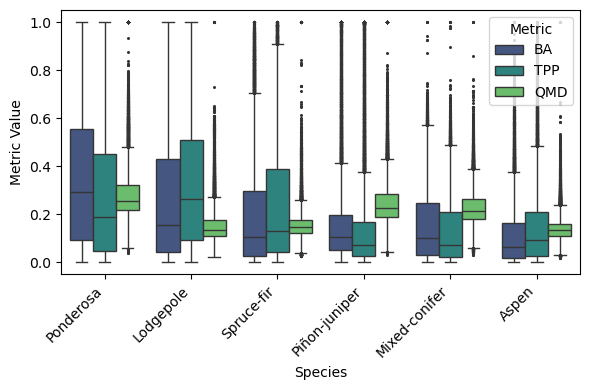

13060

In [37]:
# Plot the distribution of dominance and abundance across forest species groups
# Sort species by mean dominance
sp_order = (
    grid_tm_spp_pr.groupby('species_gp_n')['ba_ld_pr']
    .mean().sort_values(ascending=False).index
)
# Reshape the data to long format for easier plotting
df_l = pd.melt(
    grid_tm_spp_pr,
    id_vars=['species_gp_n'],
    value_vars=['ba_ld_pr', 'tpp_ld_pr', 'qmd_ld_pr'],
    var_name='metric',
    value_name='value'
)

# Set up the plot
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df_l,
    x='species_gp_n',
    y='value',
    hue='metric',
    order=sp_order,
    palette='viridis',
    flierprops=dict(marker='o', markersize=1.2)
)

# Customize the plot
plt.xlabel('Species')
plt.ylabel('Metric Value')
plt.xticks(rotation=45, ha='right')

# Customize legend labels
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = ['BA', 'TPP', 'QMD']  # New labels
plt.legend(
    handles=handles, 
    labels=new_labels,  # Replace default labels
    title='Metric', 
    loc='upper right', 
    bbox_to_anchor=(1, 1)
)

# Finalize and show the plot
plt.tight_layout()

# Save the plot
out_png = os.path.join(projdir, 'figures/FigureSX_TopSpecies_TreeMetrics_Proportions.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()

del df_l
gc.collect()

In [38]:
# save the file.
out_fp = os.path.join(projdir,'data/tabular/mod/gridstats_treetable.csv')
grid_tm_spp_pr.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/gridstats_treetable.csv


In [39]:
# merge back to the frp data
grid.drop(columns=['forest_pixels','forest_pct'], inplace=True)
grid_tm_frp = grid.merge(grid_tm_spp_pr, on='grid_index', how='inner')
grid_tm_frp.columns

Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'x', 'y', 'species_gp_n', 'tmid_n', 'forest_pct', 'ba_live', 'ba_dead',
       'ba_ld', 'tpp_live', 'tpp_dead', 'tpp_ld', 'qmd_live', 'qmd_dead',
       'qmd_ld', 'tree_ht_live', 'tree_ht_dead', 'balive_total',
       'badead_total', 'ba_ld_total', 'tpp_live_total', 'tpp_dead_total',
       'tpp_ld_total', 'qmd_live_total', '

In [43]:
del grid_tm_spp, grid_tm_spp_pr
gc.collect()

0

In [40]:
grid_tm_frp['species_gp_n'].unique()

array(['Aspen', 'Lodgepole', 'Mixed-conifer', 'Piñon-juniper',
       'Ponderosa', 'Spruce-fir'], dtype=object)

In [42]:
# Save this table out.
# First, extract centroid coords
df = grid_tm_frp.copy()
df = df.to_crs(4326) # WGS coords for lat/lon
df['x'] = df.geometry.centroid.x  # Longitude (x-coordinate)
df['y'] = df.geometry.centroid.y 
# remove the geomtry field before exporting
df.drop(columns=['geometry'], inplace=True)

# save the file.
out_fp = os.path.join(projdir,'data/tabular/mod/gridstats_treetable_frp.csv')
df.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

del df
gc.collect()

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/gridstats_treetable_frp.csv


0

In [ ]:
# Explore the data ...

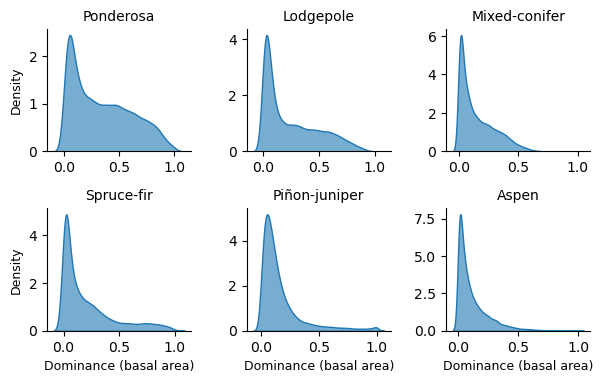

In [48]:
# plot the distribution of percent cover by forest types
grid_tm_frp['species_gp_n'] = grid_tm_frp['species_gp_n'].astype('category')

spp_order = top_species[top_species['species_gp_n'].isin(grid_tm_frp['species_gp_n'].unique())]
spp_order = spp_order['species_gp_n'].tolist()
grid_tm_frp['species_gp_n'] = pd.Categorical(
    grid_tm_frp['species_gp_n'],
    categories=spp_order,
    ordered=True
)

# Create a FacetGrid with the specified order
g = sns.FacetGrid(
    data=grid_tm_frp,
    col='species_gp_n',      
    col_wrap=3,             
    sharex=False,            
    sharey=False,            
    height=2,               
    aspect=1.2              
)

# Map a KDE plot to each facet
g.map(sns.kdeplot, 'ba_ld_pr', fill=True, alpha=0.6)

# Customize the plot
g.set_titles("{col_name}")  # Use species names as titles
g.set_axis_labels("Dominance (basal area)", "Density", size=9)  # Axis labels
g.fig.set_size_inches(6,4)  # Set figure dimensions
plt.subplots_adjust(top=0.9)  # Adjust subplot spacing

# Show the plot
plt.show()

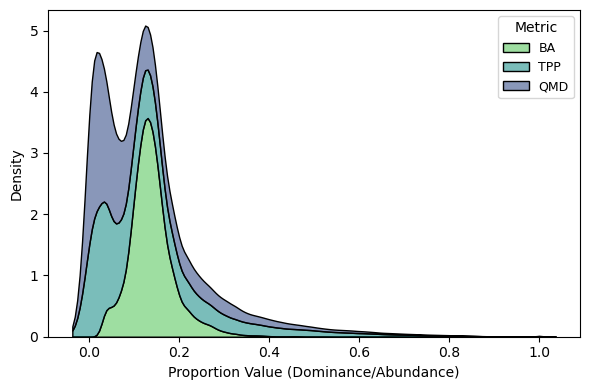

In [57]:
df_long = pd.melt(
    grid_tm_frp,
    id_vars=['species_gp_n'],
    value_vars=['ba_ld_pr', 'tpp_ld_pr', 'qmd_ld_pr'],
    var_name='metric',
    value_name='value'
)

# Set the order of species
spp_order = top_species[top_species['species_gp_n'].isin(grid_tm_frp['species_gp_n'].unique())]
spp_order = spp_order['species_gp_n'].tolist()
df_long['species_gp_n'] = pd.Categorical(
    df_long['species_gp_n'],
    categories=spp_order,
    ordered=True
)

# Just plot one species
df_long = df_long[df_long['species_gp_n'] == 'Aspen']

# Create the plot with stacked densities
plt.figure(figsize=(6,4))

# Use seaborn's KDE plot for each metric, with species as rows (stacked)
sns.kdeplot(
    data=df_long,
    x='value',
    hue='metric',  # Separate densities by metric
    multiple='stack',  # Stack densities
    fill=True,         # Fill densities for stacking effect
    palette='viridis',
    alpha=0.6
)

# Customize the plot
plt.xlabel("Proportion Value (Dominance/Abundance)", fontsize=10)
plt.ylabel("Density", fontsize=10)
plt.legend(title="Metric", labels=["BA", "TPP", "QMD"], fontsize=9)
plt.tight_layout()

# Show the plot
plt.show()

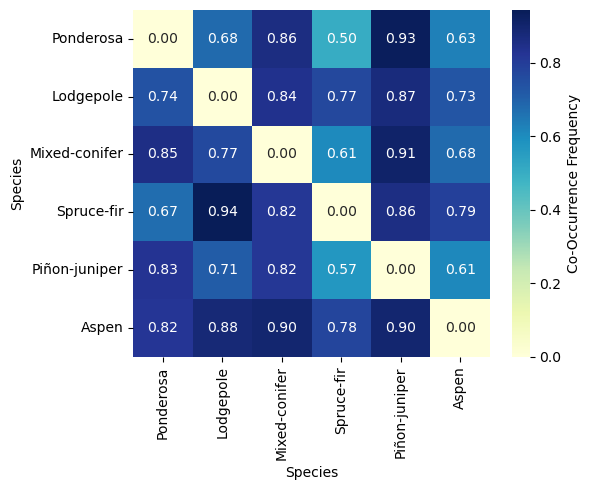

In [58]:
# Species co-occurrence plot
# Threshold species presence where dominance/abundance > 1% of total
dt = 0.01
# Create a binary presence-absence matrix
pres_abs = (
    grid_tm_frp
    .pivot_table(index='grid_index', columns='species_gp_n', values='ba_ld_pr', aggfunc='first')
    .fillna(0)
    .applymap(lambda x: 1 if x >= dt else 0)  # Convert to binary
)

# get the species names and matrix
species = pres_abs.columns
coo_mat = pd.DataFrame(0, index=species, columns=species)
# map across species combinations
for sp1, sp2 in combinations(species, 2):
    # Count co-occurrence (grids where both species are present)
    coo = np.sum(pres_abs[sp1] & pres_abs[sp2])
    coo_mat.loc[sp1, sp2] = coo
    coo_mat.loc[sp2, sp1] = coo  # Symmetry

# Optional: Normalize by the total number of grids for each species
species_totals = pres_abs.sum(axis=0)
norm_mat = coo_mat.div(species_totals, axis=0)

# Create a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(
    norm_mat, 
    annot=True, 
    fmt=".2f", 
    cmap="YlGnBu", 
    cbar_kws={'label': 'Co-Occurrence Frequency'}
)
plt.xlabel("Species")
plt.ylabel("Species")
plt.tight_layout()

out_png = os.path.join(projdir, 'figures/FigureX_Species_CoOccurrence.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')

plt.show()